In [3]:
import os.path as osp
import numpy as np
from tqdm import tqdm
import json
from glob import glob
from pandas import DataFrame
import cv2
import os
import matplotlib.pyplot as plt

In [44]:
def draw_text_det_res(dt_boxes, img):
    for box in dt_boxes:
        if len(box) == 4:
            box = [box[0], box[1], box[2], box[1],
                box[2], box[3], box[0], box[3]]
        box = np.array(box).astype(np.int32).reshape(-1, 2)
        cv2.polylines(img, [box], True, color=(255, 0, 0), thickness=3)
    return img


def parse_semantic_children(data, store):
	for item in data:
		tmp = dict()
		for key, value in item.items():
			if key == 'children':
				parse_semantic_children(value, store)
			elif key == 'bounds':
				tmp[key] = value
			elif key == 'componentLabel':
				tmp[key] = value
		# 当前节点没有children的时候才加入到列表中
		if 'children' not in list(item.keys()):
			store.append(tmp)
	return store


def parse_semantic_ann(path):
	with open(path) as f:
		content = f.read()
	content = json.loads(content)
	border = []
	children_data = []
	for key, value in content.items():
		item = dict()
		if key == 'bounds':
			border = value
		elif key == 'children':
			parse_semantic_children(value, children_data)

	return border, children_data


def unique_points(data):
	bounds = [','.join(map(str, d['bounds'])) for d in data]
	labels = [d['componentLabel'] for d in data]

	df_data = DataFrame(data={'bounds': bounds, 'labels': labels}, columns=[
	                    'bounds', 'labels'])
	unique_data = df_data.drop_duplicates()
	return unique_data


  0%|          | 0/66261 [00:00<?, ?it/s]

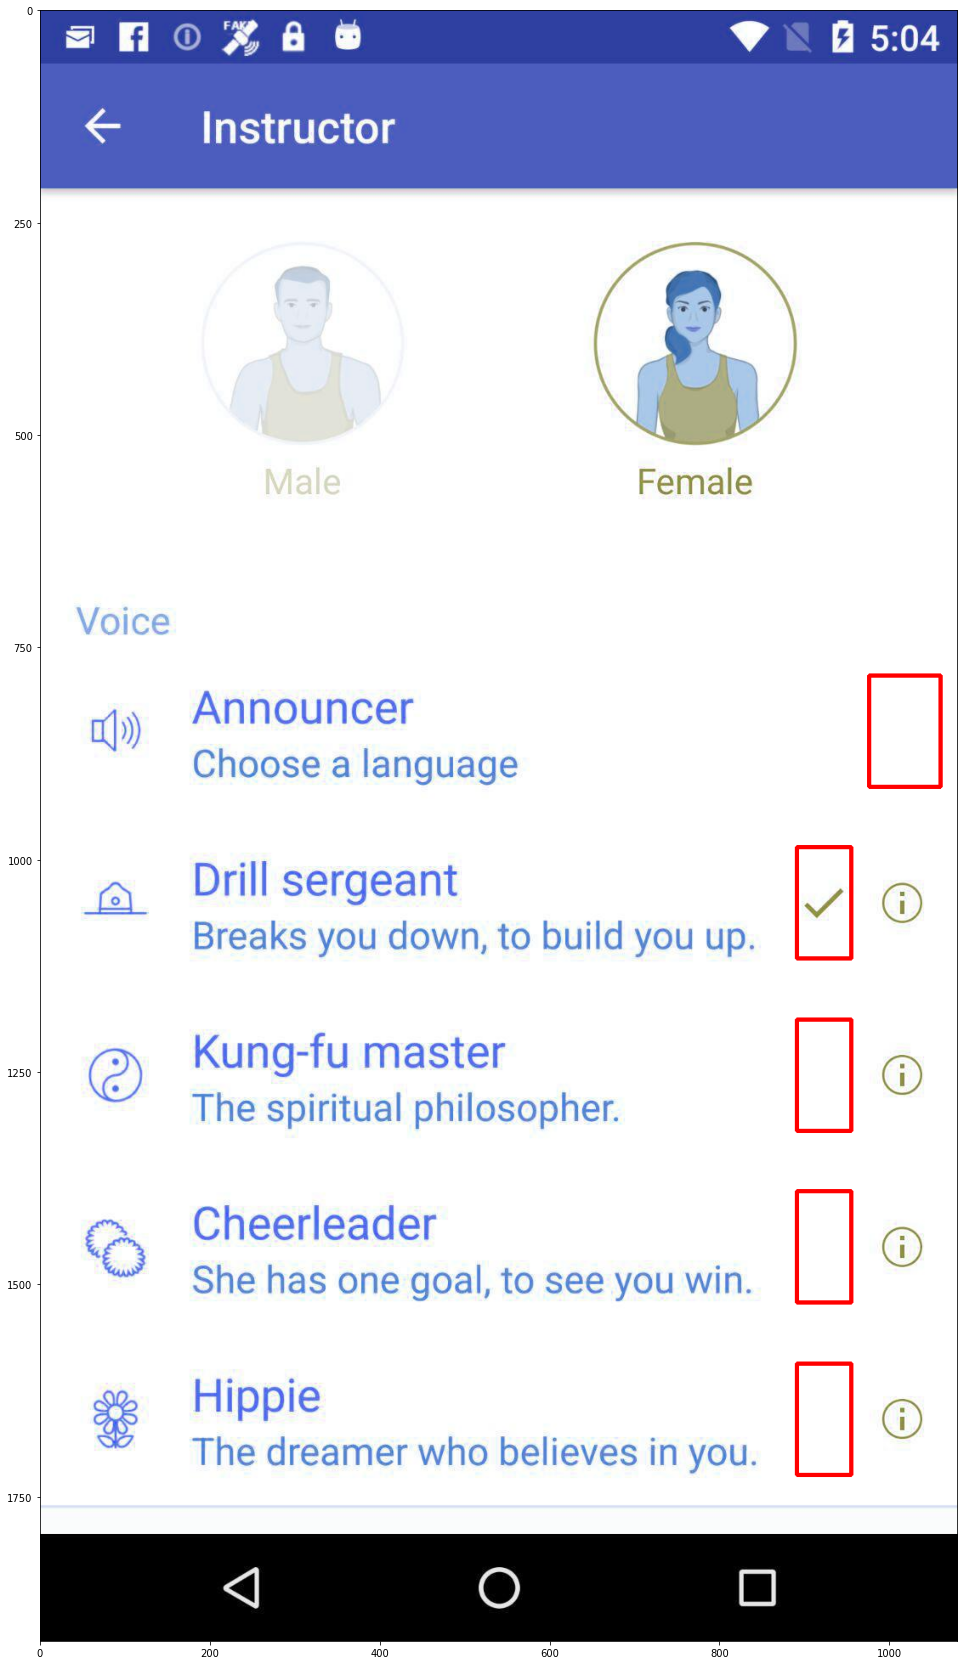

  0%|          | 0/66261 [00:00<?, ?it/s]


In [51]:

root = '/mnt/data/rz/data/UIDetect/combined/'
org_img_root = osp.join(root, 'images')
cutted_img_store_root = osp.join(root, 'cutted')
if not osp.exists(cutted_img_store_root):
	os.makedirs(cutted_img_store_root)
ann_path = osp.join(root, 'semantic_annotations', '*.json')
ann_paths = glob(ann_path)

plt.figure(figsize=(30, 30))
for annp in tqdm(ann_paths):
	annp = osp.join(root, 'semantic_annotations', '11.json')
	imgn = osp.basename(annp).replace('json', 'jpg')
	sem_img_path = osp.join(root, 'semantic_annotations', imgn.replace('jpg', 'png'))
	border, elements = parse_semantic_ann(annp)
	org_img_path = osp.join(org_img_root, imgn)
	org_img = cv2.imread(org_img_path)
	h, w = org_img.shape[:2]
	semH, semW = cv2.imread(sem_img_path).shape[:2]
	ratioH, ratioW = h / semH, w / semW

	boxes = [d['bounds'] for d in elements if d['componentLabel'] == 'Checkbox']
	# boxes = [d['bounds'] for d in elements ]
	boxes = np.array(boxes)
	boxes = boxes.reshape((-1, 2, 2))
	boxes[:, :, 0] = boxes[:, :, 0] * ratioW
	boxes[:, :, 1] = boxes[:, :, 1] * ratioH
	x1, y1, x2, y2 = border
	boxes = boxes.reshape((-1, 4))
	drawed_img = draw_text_det_res(boxes, org_img)
	plt.imshow(drawed_img)
	plt.show()

	break
	
